<a href="https://colab.research.google.com/github/davidemichelon11/DL_Assignment/blob/main/DAC-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Assignment

#### Giulio Mattolin 224072

#### Davide Michelon 229313

In this work, we implement the architecture and method formulated in the paper "Domain Attention Consistency for Multi-Source Domain Adaptation" [1] available at the following link: https://arxiv.org/abs/2111.03911. 

Moreover, to improve the performance of the model and obtain better adaptation results, we introduce a novel approach which takes advantage of a convolutional Discriminator with Gradient Reversal Layer (GRL) and features gradually modulated by the attention to promote the extraction of domain-invariant features, initially focusing on the global features and then, as the training proceeds, focusing on the features highlighted by the channel attention.

# Import libraries

In [1]:
from google.colab import drive
import os
import shutil
from tqdm import tqdm
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Function
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import ResNet18_Weights, ResNet34_Weights, ResNet50_Weights, ResNet101_Weights, ResNet152_Weights
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import random
import numpy as np
from collections import defaultdict
import math

# Extract data and create dataset

In [ ]:
drive.mount('/content/gdrive')

In [ ]:
!unzip -q -o gdrive/MyDrive/Adaptiope.zip 

In [ ]:
classes = ["/backpack", "/bookcase", "/car jack", "/comb", "/crown", "/file cabinet", "/flat iron", "/game controller", "/glasses",
           "/helicopter", "/ice skates", "/letter tray", "/monitor", "/mug", "/network switch", "/over-ear headphones", "/pen",
           "/purse", "/stand mixer", "/stroller"]

for d, td in zip(["Adaptiope/product_images", "Adaptiope/real_life"], ["adaptiope_small/product_images", "adaptiope_small/real_life"]):
  os.makedirs(td)
  for c in tqdm(classes):
    c_path = ''.join((d, c))
    c_target = ''.join((td, c))
    shutil.copytree(c_path, c_target)

# Create dataloader

This code defines a function `get_data()` and it takes four parameters as input:


*   `batch_size`: the number of data samples per batch to be loaded in memory at a time 
*   `product_root`: the path to the directory containing the product domain images.
*   `real_root`: the path to the directory containing the real domain images.
*   `num_ops`: number of data augmentations for RandAugment transformation.
*   `magnitude`: size of the data augmentations for RandAugment transformation.


The function creates two separate lists of transformations, one is a soft transformation which contains Resize, RandomCrop and normalization, the other is a strong transformation which contains all the previous transformation plus RandAugment.

After that, we created four separate datasets, one for the product domain with soft transformation, one for the real domain with soft transformation, one for the product domain with strong transformation and one for the real domain with strong transformation.

Next, the code splits the data into training and test sets, using 80% of the data for training and 20% for testing. We use the same generator seed for the product datasets and the same generator seed for the real datasets to make sure that the images contained in the datasets of the same domain are equal and only the applied augmentation differs. We take the same approach also to initialize the RandomSampler, so that the same images are sampled from datasets of the same domain.

Finally, the code creates four data loaders, one for each dataset. The data loaders are PyTorch objects that allow easy iteration through the data, loading batches of images in memory as needed during training.


In [ ]:
def get_data(batch_size, product_root, real_root, num_ops=2, magnitude=10):
  # resizing and cropping
  # prepare data transformations for the train loader
  transform = list()
  transform.append(T.Resize((256, 256)))                      # resize each PIL image to 256 x 256
  transform.append(T.RandomCrop((224, 224)))                 # randomly crop a 224 x 224 patch
  transform.append(T.ToTensor())                              # convert Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225]))    # normalize with ImageNet mean
  
  # compose the above transformations into weak and strong (which has RandAugment in addition)
  transform_weak = T.Compose(transform.copy())
  transform_strong = T.Compose(transform.copy())                           
  transform_strong.transforms.insert(0, T.RandAugment(num_ops, magnitude))
    
  # load data
  dataset_prod = torchvision.datasets.ImageFolder(root=product_root, transform=transform_weak)
  dataset_prod_aug = torchvision.datasets.ImageFolder(root=product_root, transform=transform_strong)
  dataset_real = torchvision.datasets.ImageFolder(root=real_root, transform=transform_weak)
  dataset_real_aug = torchvision.datasets.ImageFolder(root=real_root, transform=transform_strong)
  
  # create train and test splits (80/20)
  num_samples = len(dataset_prod) # same number of samples among datasets
  training_samples = int(num_samples * 0.8 + 1)
  test_samples = num_samples - training_samples

  train_data_prod, test_data_prod = torch.utils.data.random_split(dataset_prod, [training_samples, test_samples], generator=torch.Generator().manual_seed(1))
  train_data_prod_aug, test_data_prod_aug = torch.utils.data.random_split(dataset_prod_aug, [training_samples, test_samples], generator=torch.Generator().manual_seed(1))
  train_data_real, test_data_real = torch.utils.data.random_split(dataset_real, [training_samples, test_samples], generator=torch.Generator().manual_seed(2))
  train_data_real_aug, test_data_real_aug = torch.utils.data.random_split(dataset_real_aug, [training_samples, test_samples], generator=torch.Generator().manual_seed(2))

  # initialize sampler to get same data from weak and augment
  sampler_prod = torch.utils.data.RandomSampler(train_data_prod, generator=torch.Generator().manual_seed(1))
  sampler_prod_aug = torch.utils.data.RandomSampler(train_data_prod_aug, generator=torch.Generator().manual_seed(1))
  sampler_real = torch.utils.data.RandomSampler(train_data_real, generator=torch.Generator().manual_seed(2))
  sampler_real_aug = torch.utils.data.RandomSampler(train_data_real, generator=torch.Generator().manual_seed(2))

  # initialize dataloaders
  train_loader_prod = torch.utils.data.DataLoader(train_data_prod, batch_size, sampler=sampler_prod)
  test_loader_prod = torch.utils.data.DataLoader(test_data_prod, batch_size, shuffle=False)
  train_loader_prod_aug = torch.utils.data.DataLoader(train_data_prod_aug, batch_size, sampler=sampler_prod_aug)
  test_loader_prod_aug = torch.utils.data.DataLoader(test_data_prod_aug, batch_size, shuffle=False)
  
  train_loader_real = torch.utils.data.DataLoader(train_data_real, batch_size, sampler=sampler_real)
  test_loader_real = torch.utils.data.DataLoader(test_data_real, batch_size, shuffle=False)
  train_loader_real_aug = torch.utils.data.DataLoader(train_data_real_aug, batch_size, sampler=sampler_real_aug)
  test_loader_real_aug = torch.utils.data.DataLoader(test_data_real_aug, batch_size, shuffle=False)
  
  return (train_loader_prod, test_loader_prod), (train_loader_prod_aug, test_loader_prod_aug), (train_loader_real, test_loader_real), (train_loader_real_aug, test_loader_real_aug)

# Create model

The authors of the paper [1] propose a new model called DAC-Net, which uses a feature channel attention module to identify transferable features. The attention module is supervised by a consistency loss, which is imposed on the distributions of channel attention weights between source and target domains. Additionally, to improve the discriminative feature learning on the target data, the authors use pseudo-labeling and class compactness loss to minimize the distance between the target features and the classifier's weight vectors.

Our proposal takes advantage of the channel attention by gradually modulating the features which are fed to a convolutional Discriminator with GRL to promote during training the extraction of domain-invariant features. 

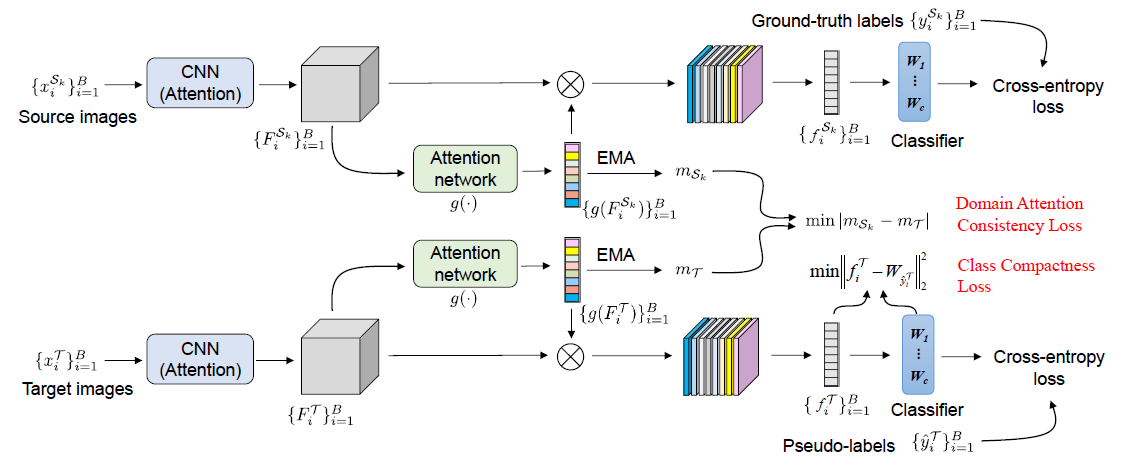

### Channel attention module

The design of the attention network follows the one proposed in the paper "CBAM: Convolutional Block Attention Module" [2] https://arxiv.org/abs/1807.06521. With attention modeling for each image, DAC-Net is encouraged to use a subset of the feature channels to explain the image content, therefore facilitating the discovery of transferable latent attributes.

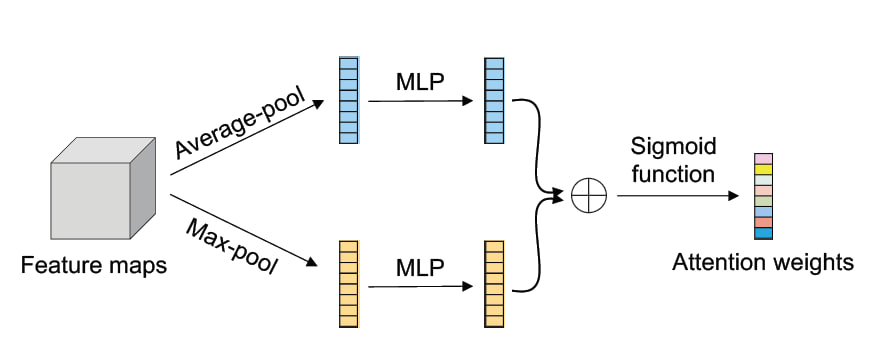

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

### Discriminator module

The design of the discriminator network is similar to the developed in the paper "Every Pixel Matters: Center-aware Feature Alignment for Domain Adaptive Object Detector" [3] https://arxiv.org/abs/2008.08574. It is composed of 2 sets of Conv2d, GroupNorm and ReLU followed by a convolutional classification head. Differently from the paper implementation, the $\lambda$ of the GRL is an argument passed in input to the Discriminator, since in the original paper "Unsupervised Domain Adaptation by Backpropagation" [4] https://arxiv.org/abs/1409.7495 its value is changing across training iterations and we wanted to try to do the same.

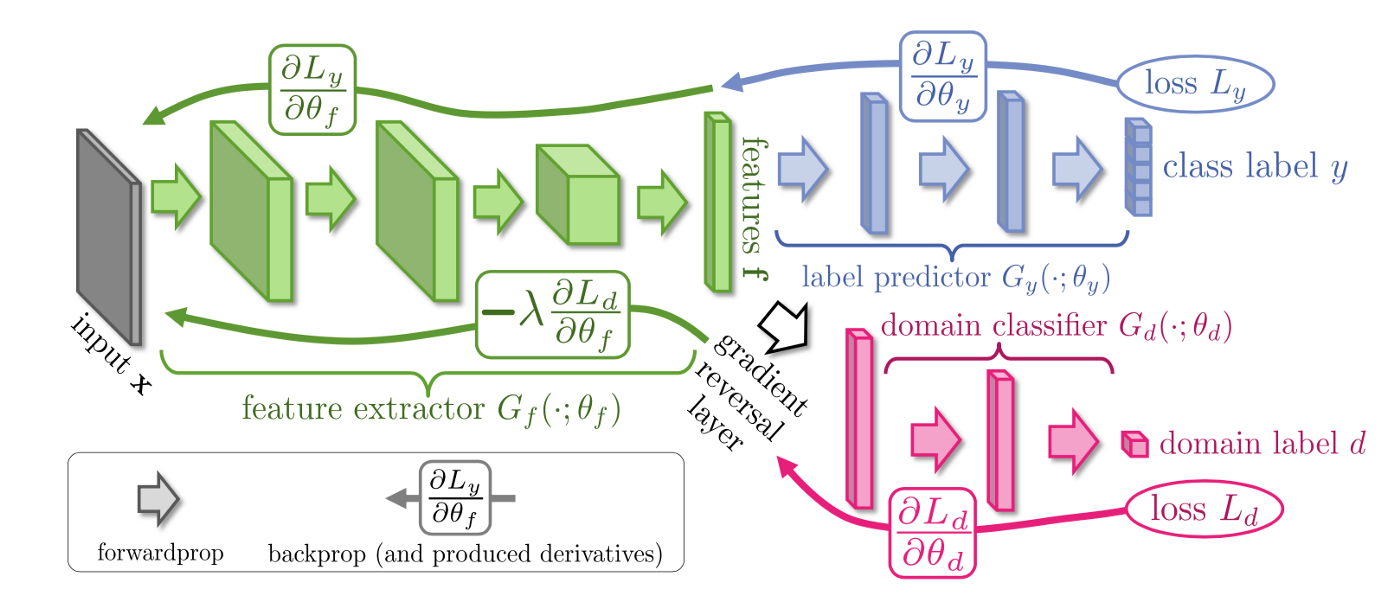

In [ ]:
class DiscriminatorConv(nn.Module):
    def __init__(self, c1, num_convs=2):
        super().__init__()
        self.rev = GradientReversal()

        dis_tower = []
        for _ in range(num_convs):
            dis_tower.append(
                nn.Conv2d(
                    c1,
                    c1,
                    kernel_size=3,
                    stride=1,
                    padding=1
                )
            )
            dis_tower.append(nn.GroupNorm(32, c1))
            dis_tower.append(nn.ReLU())

        self.add_module('dis_tower', nn.Sequential(*dis_tower))

        self.cls_logits = nn.Conv2d(
            c1, 1, kernel_size=3, stride=1,
            padding=1
        )

        # initialization
        for modules in [self.dis_tower, self.cls_logits]:
            for l in modules.modules():
                if isinstance(l, nn.Conv2d):
                    torch.nn.init.normal_(l.weight, std=0.01)
                    torch.nn.init.constant_(l.bias, 0)
    
    def forward(self, x, lambda_):
        x = self.rev(x, lambda_)
        
        x = self.dis_tower(x)
        x = self.cls_logits(x)
        return x


class GradientReversal(torch.nn.Module):
    def __init__(self):
        super(GradientReversal, self).__init__()

    def forward(self, x, lambda_):
        return GradientReversalFunction.apply(x, lambda_)


class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None

### BasicBlock and Bottleneck modules of ResNet

The architecture used in the paper [1] is a ResNet. Here we implement the class `BasicBlock`, which includes two convolutional layers, batch normalization layers, and a ReLU activation function. The `BasicBlock` also includes a `ChannelAttention` module, which has been described in the previous section. The class `Bottleneck` is similar to `BasicBlock` and can be used in bigger ResNet architecture, to increase the capacity of the model to learn more complex features from the input data. However, this also increases the number of parameters in the network and thus requires more resources to train and run.

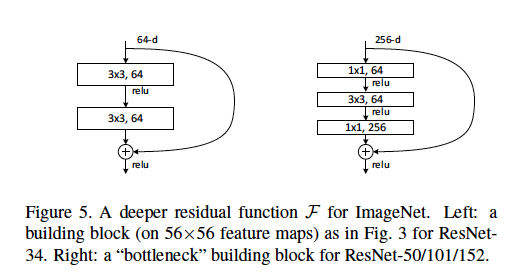

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_attention=True, output_attention=False):
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.ca = ChannelAttention(planes)
        self.downsample = downsample
        self.stride = stride
        self.output_attention = output_attention
        self.use_attention = use_attention

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if self.use_attention:
            out_ca = self.ca(out)
            out = residual + out_ca * out
        else:
            out = residual + out
            out_ca = []
        out = self.relu(out)
        if self.output_attention:
            return out, out_ca
        else:
            return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_attention=True, output_attention=False):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, planes * self.expansion, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.ca = ChannelAttention(planes * self.expansion)
        self.downsample = downsample
        self.stride = stride
        self.output_attention = output_attention
        self.use_attention = use_attention

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if self.use_attention:
            out_ca = self.ca(out)
            out = residual + out_ca * out
        else:
            out = residual + out
            out_ca = []
        out = self.relu(out)
        if self.output_attention:
            return out, out_ca
        else:
            return out

### ResNet architecture with channel attention

The `ResNet` class initializes the ResNet architecture by defining the convolutional, batch normalization and pooling layers of the network. The architecture also includes an attention mechanism in its layers and a `DiscriminatorConv` layer, added to implement our proposal. The class is defined by the input parameters `block` and `layers`and has several methods: the `_make_layer` method creates the layers of the architecture, the `_init_params` method initializes the parameters of the layers, the `featuremaps` method returns the feature maps of the input data and the `predictions` method returns the predictions made by the classification layer. The `forward` method of the model takes as input the image sample and other two parameters which are: the $\lambda$ of the GRL of the Discriminator and $\delta$ which is used to control the modulation of the feature map fed to the Discriminator with the channel attention.

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers):
        self.inplanes = 64
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], use_attention=False)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, use_attention=False)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, use_attention=True)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, use_attention=True)
        self.disc = DiscriminatorConv(512 * block.expansion)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, 1000)

        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        #     elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        #         nn.init.constant_(m.weight, 1)
        #         nn.init.constant_(m.bias, 0)

        self._init_params()


    def _make_layer(self, block, planes, blocks, stride=1, use_attention=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_attention=use_attention))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == blocks - 1:
                layers.append(block(self.inplanes, planes, output_attention=True, use_attention=use_attention))
            else:
                layers.append(block(self.inplanes, planes, use_attention=use_attention))

        return nn.Sequential(*layers)

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu'
                )
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def featuremaps(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x, out_ca1 = self.layer1(x)
        x, out_ca2 = self.layer2(x)
        x, out_ca3 = self.layer3(x)
        x, out_ca4 = self.layer4(x)
        return x, [out_ca1, out_ca2, out_ca3, out_ca4]

    def predictions(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def forward(self, x, lambda_=0, delta=0):
        f, channel_attention = self.featuremaps(x)

        # domain = self.disc(f, lambda_)

        # modulate the features given in input to the discriminator using the
        # channel attention extracted by the last layer (we use the last since
        # it has the same size of the features map)
        # the parameter delta controls the modulation process
        domain = self.disc(channel_attention[-1]*f*delta + f*(1-delta), lambda_)

        v = self.avgpool(f)

        out = self.predictions(v)
        
        return out, v, channel_attention, domain

### Get model function

The function `get_model` takes in three arguments: `resnet`, `pretrained` and `num_classes`. The function creates an instance of the ResNet model with a specific architecture (determined by the resnet argument) and layers configuration. The argument resnet can take one of the values 18, 34, 50, 101, 152. If the `pretrained` argument is set to `True`, the function loads the pre-trained weights of the model. The final fully connected layer of the model is then modified to have `num_classes` output neurons. The function returns the created model.

In the project, the default version of ResNet with the `BasicBlock` and `layers =[2, 2, 2, 2]` was used consistently. However, the code for other versions of ResNet such as ResNet with `Bottleneck` and different number of layers were included for completeness.

In [ ]:
def get_model(resnet=18, pretrained=False, num_classes=20):
  if resnet == 18:
    model = ResNet(block=BasicBlock, layers=[2, 2, 2, 2])
    weights = ResNet18_Weights.IMAGENET1K_V1
  elif resnet == 34:
    model = ResNet(block=BasicBlock, layers=[3, 4, 6, 3])
    weights = ResNet34_Weights.IMAGENET1K_V1
  elif resnet == 50:
    model = ResNet(block=Bottleneck, layers=[3, 4, 6, 3])
    weights = ResNet50_Weights.IMAGENET1K_V1
  elif resnet == 101:
    model = ResNet(block=Bottleneck, layers=[3, 4, 23, 3])
    weights = ResNet101_Weights.IMAGENET1K_V1
  elif resnet == 152:
    model = ResNet(block=Bottleneck, layers=[3, 8, 36, 3])
    weights = ResNet152_Weights.IMAGENET1K_V1
  else:
    print("Unable to identify the ResNet architecture")
    return

  if pretrained:
    model.load_state_dict(weights.get_state_dict(progress=True), strict=False)

  model.fc = nn.Linear(model.fc.in_features, num_classes)

  return model

# Specify optimizer and scheduler

The `get_optimizer` function takes in a PyTorch model, a learning rate, weight decay, momentum, and an optimization algorithm as input parameters. It then creates an optimizer object based on the specified algorithm, and sets the learning rate, weight decay, and momentum accordingly. It returns the optimizer object.

The `get_scheduler` function takes in an optimizer, the number of training epochs, and a learning rate scheduling algorithm as input parameters. It then creates a learning rate scheduler object based on the specified algorithm, and sets the number of training epochs accordingly. It returns the scheduler object.

During the experiment, we always used the optimizer `Adam`, with a `learning rate= 5e-4`, `epoches=20` and the scheduler `cosine` for the learning rate schedule.

In [ ]:
def get_optimizer(model, lr, wd=0, momentum=0, opt='Adam'):
  if opt == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  elif opt == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  
  return optimizer

In [ ]:
def get_scheduler(optimizer, epochs, sched='cosine'):
  if sched == 'cosine':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
  
  return scheduler

# Train model

This code is defining a training step function for training the model. The function takes in several parameters including the model, the training data loaders for the source and target datasets, the optimizer, and several weight parameters for different losses. The function then iterates over the training data and for each batch calculates several different losses:
*   **Supervised loss:** It is calculated using the cross-entropy loss function on the output of the model for the source data and the corresponding labels.
*   **Unsupervised pseudo loss:** It is calculated by applying a cross-entropy loss between the target dataset with the strong transformation and the pseudo labels generated from the output of the model on the target dataset with weak transformation, with the additional constraint of only considering samples with a high confidence level as determined by a threshold..
*   **Domain attention consistency loss:** It is calculated using the attention maps generated by the model. The purpose of this loss is to minimize the distribution divergence of channel attention weights between
each pair of source and target domains.
*   **Compactness loss:** It encourages the target features to be close to the corresponding classification weight vectors. Essentially, the loss
pulls together the target features and the classifier’s weight vectors to facilitate discriminative target feature learning.
*   **Adversarial-attention loss:** It encourages the extraction of target features which cannot be distinguished from the source ones, considering in the first iterations the whole feature space and, as the training proceeds, gradually narrowing to only the features highlighted by the channel attention.



In [ ]:
def training_step(model, source_train_loader, target_train_loader, optimizer, 
                  pseudo=0., attn=0., comp=0., adv=0., device='cuda:0', show_img=False, ep=False):
  
  source_train_loader, source_train_loader_aug = source_train_loader
  target_train_loader, target_train_loader_aug = target_train_loader

  source_samples = 0.
  target_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_accuracy = 0.

  weight_pseudo = pseudo
  weight_attn = attn
  weight_comp = comp
  weight_adv = adv

  ema_alpha = 0.999
  tar_ca_last1 = torch.tensor(1.)
  tar_ca_last2 = torch.tensor(1.)
  src_ca_last1 = torch.tensor(1.)
  src_ca_last2 = torch.tensor(1.)

  conf_threshold = 0.95

  mloss_source = torch.zeros(1)
  mloss_pseudo = torch.zeros(1)
  mloss_attn = torch.zeros(1)
  mloss_comp = torch.zeros(1)
  mloss_adv = torch.zeros(1)

  if show_img:
    mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
    std = np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)
  
  target_iter = iter(target_train_loader)
  target_iter_aug = iter(target_train_loader_aug)

  # strictly needed if network contains layers which has different behaviours between train and test
  model.train()

  pbar = tqdm(zip(source_train_loader, source_train_loader_aug), total=len(source_train_loader))

  epoch, epochs = ep
  nb = len(source_train_loader)
  max_iterations = nb * epochs

  for i, ((inputs_source, targets_source), (inputs_source_aug, _)) in enumerate(pbar):
    
    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, _ = next(target_iter)
      inputs_target_aug, _ = next(target_iter_aug)
    except:
      target_iter = iter(target_train_loader)
      target_iter_aug = iter(target_train_loader_aug)

      inputs_target, _ = next(target_iter)
      inputs_target_aug, _ = next(target_iter_aug)

    # input_weak = torch.cat([inputs_source, inputs_target], dim=0) 
    # input_strong = torch.cat([inputs_source_aug, inputs_target_aug], dim=0)

    targets_domain = torch.cat(
        (torch.zeros(inputs_source.shape[0]), torch.ones(inputs_target.shape[0]))
    ).unsqueeze(dim=1)

    # load data into device
    inputs_source, inputs_target = inputs_source.to(device), inputs_target.to(device)
    # input_weak, input_strong = input_weak.to(device), input_strong.to(device)
    inputs_target_aug = inputs_target_aug.to(device)
    targets_source, targets_domain = targets_source.to(device), targets_domain.to(device)


    # -----------------------------------
    # Supervised loss
    # -----------------------------------

    output_source, _, ca_source, _ = model(inputs_source)
    loss_source = F.cross_entropy(output_source, targets_source)


    # -----------------------------------
    # Generate artificial label
    # -----------------------------------

    with torch.no_grad():
      output_weak, _, _, _ = model(inputs_target)
      max_prob, label_weak = F.softmax(output_weak, dim=1).max(dim=1)
      mask_pseudo = (max_prob >= conf_threshold).float()


    # -----------------------------------
    # Unsupervised pseudo loss
    # -----------------------------------
    
    loss_pseudo = torch.tensor(0.).to(device)

    if pseudo:
      output_strong, feat_strong, ca_strong, _ = model(inputs_target_aug)
      loss_pseudo = F.cross_entropy(output_strong, label_weak, reduction='none')
      loss_pseudo = (loss_pseudo * mask_pseudo).mean()

    # -----------------------------------
    # Domain attention consistency loss
    # -----------------------------------

    loss_attn = torch.tensor(0.).to(device)

    if attn:
      # DAC loss for the fourth residual block
      mean_tar_ca1 = tar_ca_last1 * ema_alpha + (1. - ema_alpha) * torch.mean(ca_strong[-1], 0)
      tar_ca_last1 = mean_tar_ca1.detach()

      mean_src_ca1 = src_ca_last1 * ema_alpha + (1. - ema_alpha) * torch.mean(ca_source[-1], 0)
      src_ca_last1 = mean_src_ca1.detach()

      loss_attn += torch.mean(torch.abs(mean_src_ca1 - mean_tar_ca1))

      # DAC loss for the third residual block
      mean_tar_ca2 = tar_ca_last2 * ema_alpha + (1. - ema_alpha) * torch.mean(ca_strong[-2], 0)
      tar_ca_last2 = mean_tar_ca2.detach()

      mean_src_ca2 = src_ca_last2 * ema_alpha + (1. - ema_alpha) * torch.mean(ca_source[-2], 0)
      src_ca_last2 = mean_src_ca2.detach()

      loss_attn += torch.mean(torch.abs(mean_src_ca2 - mean_tar_ca2))


    # -----------------------------------
    # Class compactness loss
    # -----------------------------------
    
    loss_comp = torch.tensor(0.).to(device)

    if comp:
      with torch.no_grad():
        img_shape = inputs_target.shape

        # enforce class compactness loss only on target samples that have consistent prediction under Guassian noise
        noise = torch.randn(img_shape[0], img_shape[1], img_shape[2], img_shape[3]) * 0.15
        input_noise = torch.flip(inputs_target, [3]) + noise.to(device)
        output_noise, feat_noise, _, _ = model(input_noise)
        max_prob, label_noise = F.softmax(output_noise, dim=1).max(1)
        mask_noise = (max_prob >= conf_threshold).float()

        # create mask to filter samples whose prediction is not consistent under Guassian noise
        # or that under weak augmentation or noise where predicted with confidence below threshold
        label_cons = (label_weak == label_noise).float()
        mask_cons = mask_pseudo * mask_noise * label_cons

        if mask_cons.sum() > 0: # check if there is at least one sample that satisfy the contraints
          weight = model.fc.weight
          # feat_strong has shape [60, 512, 1, 1] while weight[label_weak, :] has shape [60, 512]
          # so squeeze feat_strong to shape [60, 512], removing unnecessary dimensions
          # moreover, mask_cons has shape [60] thus unsqueeze to [60, 1] to have same number of dimensions as other two
          diff = mask_cons.unsqueeze(dim=1) * (feat_strong.squeeze() - weight[label_weak, :])
          loss_comp = weight_comp * torch.mean(diff * diff)


    # -----------------------------------
    # Adversarial-attention loss
    # -----------------------------------

    loss_adv = torch.tensor(0.).to(device)
    
    if adv:
      # current iteration
      ni = i + nb * epoch
      # current iteration / max number of iterations
      r = ni / max_iterations
      # lambda value proposed in the original GRL paper (goes from 0 to 1)
      gamma = 2 / (1 + math.exp(-10 * r)) - 1

      # we set lambda for the GRL to be fixed and use the value proposed in  
      # the original paper of the GRL to control the modulation of the features
      # passed in input to the Discriminator with the attention
      _, _, _, domain_source = model(inputs_source, 0.01, gamma)
      _, _, _, domain_target = model(inputs_target, 0.01, gamma)

      pred_domain = torch.cat((domain_source, domain_target))
      true_domain = torch.cat((torch.zeros(domain_source.shape), torch.ones(domain_target.shape))).to(device)

      loss_adv = F.binary_cross_entropy_with_logits(pred_domain, true_domain)    


    # -----------------------------------
    # Backpropagation
    # -----------------------------------

    loss = loss_source + loss_pseudo * weight_pseudo + loss_attn * weight_attn + loss_comp * weight_comp + loss_adv * weight_adv

    # backward pass
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # reset the optimizer
    optimizer.zero_grad()

    # print statistics
    source_samples += inputs_source.shape[0]
    target_samples += inputs_target.shape[0]
    
    cumulative_ce_loss += loss_source.item()
    _, predicted = F.softmax(output_source, dim=1).max(dim=1)
    cumulative_accuracy += predicted.eq(targets_source).sum().item()

    mloss_source = (mloss_source * i + loss_source.item()) / (i + 1)
    mloss_pseudo = (mloss_pseudo * i + loss_pseudo.item()) / (i + 1)
    mloss_attn = (mloss_attn * i + loss_attn.item()) / (i + 1)
    mloss_comp = (mloss_comp * i + loss_comp.item()) / (i + 1)
    mloss_adv = (mloss_adv * i + loss_adv.item()) / (i + 1)
    pbar.set_description("Source loss {} | Pseudo loss {} | Attn loss {} | Comp loss {} | Adv loss {}".format(round(mloss_source.item(),4), round(mloss_pseudo.item(),4), round(mloss_attn.item(),4), round(mloss_comp.item(),4), round(mloss_adv.item(),4)))

    if show_img and i < 3:
      fig = plt.figure()
      
      ax1 = fig.add_subplot(1,4,1)
      ax1.imshow(np.clip(inputs_source[0].permute(1,2,0).cpu() * std + mean, 0, 1))
      ax2 = fig.add_subplot(1,4,2)
      ax2.imshow(np.clip(inputs_source_aug[0].permute(1,2,0).cpu() * std + mean, 0, 1))
      ax3 = fig.add_subplot(1,4,3)
      ax3.imshow(np.clip(inputs_target[0].permute(1,2,0).cpu() * std + mean, 0, 1))
      ax4 = fig.add_subplot(1,4,4)
      ax4.imshow(np.clip(inputs_target_aug[0].permute(1,2,0).cpu() * std + mean, 0, 1))

      [axi.set_axis_off() for axi in [ax1, ax2, ax3, ax4]]
      plt.show()

  return cumulative_ce_loss/source_samples, cumulative_accuracy/source_samples*100

Here we define a test step function for testing the model. The function takes in several parameters including the model, the target test data loader and iterates over the data and calculating and returning the cross-entropy loss on the classification predictions made by the model over the test set of the target domain.

In [ ]:
def test_step(model, target_test_loader, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # strictly needed if network contains layers which has different behaviours between train and test
  model.eval()

  with torch.no_grad():

    for batch_idx, (inputs, targets) in enumerate(tqdm(target_test_loader)):

      # load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
        
      # forward pass
      output, _, _, _ = model(inputs)

      # apply the loss
      loss = F.cross_entropy(output, targets)

      # print statistics
      samples += inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = F.softmax(output, dim=1).max(dim=1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

# Execute everything

In order to have reproducible results, at the start of each run we set a seed. The code in the following cells, sets the hyperparameters regarding the batch size, learning rate and number of epochs, which in every training were kept fixed. Moreover, it loads the dataloaders, the model, the optimizer and the scheduler. In the last cell, it is possible to set the hyperparameters regarding the losses and which dataset should be considered as source and which as target, and start the training.

In [ ]:
# Initialize random number generator (RNG) seeds https://pytorch.org/docs/stable/notes/randomness.html
# cudnn seed 0 settings are slower and more reproducible, else faster and less reproducible
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
cudnn.benchmark, cudnn.deterministic = (False, True)

In [ ]:
batch_size = 60
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
learning_rate = 5e-4
epochs = 20

prod_root = 'adaptiope_small/product_images'
real_root = 'adaptiope_small/real_life'

dataloaders_prod, dataloaders_prod_aug, dataloaders_real, dataloaders_real_aug= get_data(batch_size, prod_root, real_root)

train_loader_prod, test_loader_prod = dataloaders_prod
train_loader_prod_aug, test_loader_prod_aug = dataloaders_prod_aug

train_loader_real, test_loader_real = dataloaders_real
train_loader_real_aug, test_loader_real_aug = dataloaders_real_aug

model = get_model(pretrained=True).to(device)

# model.load_state_dict(torch.load('./model_weights.pt'))

optimizer = get_optimizer(model, learning_rate)

scheduler = get_scheduler(optimizer, epochs)

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for e in range(epochs):
  print('Epoch: {}/{}'.format(e+1, epochs))
  train_ce_loss, train_accuracy = training_step(
    model=model,
    source_train_loader=(train_loader_prod, train_loader_prod_aug),
    target_train_loader=(train_loader_real, train_loader_real_aug),
    # source_train_loader=(train_loader_real, train_loader_real_aug),
    # target_train_loader=(train_loader_prod, train_loader_prod_aug),
    optimizer=optimizer,
    pseudo=0.1, # 1.,
    attn=0., # 0.3,
    comp=0., # 0.1,
    adv=0., # 0.3,
    device=device, 
    show_img=False,
    ep=[e, epochs]
  )
  
  scheduler.step()
  
  test_loss, test_accuracy = test_step(
    model=model, 
    target_test_loader=test_loader_real, 
    device=device
  )
  if test_accuracy > best_accuracy:
    # torch.save(model.state_dict(), './model_weights.pt')
    best_accuracy = test_accuracy

  history['train_acc'].append(train_accuracy)
  history['train_loss'].append(train_ce_loss)
  history['test_acc'].append(test_accuracy)
  history['test_loss'].append(test_loss)
  # print('Train: CE loss {:.5f}, Accuracy {:.2f}'.format(train_ce_loss, train_accuracy))
  print('Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

# Experimental Results

*All experiments were run with seed = 0, pretrained = True, batch size = 60, optimizer = Adam, learning_rate = 5e-4, scheduler = cosine, epochs = 20.*

We illustrate the results obtained using the product dataset as source and the real dataset as target, i.e. Prod &rarr; Real, and also the real dataset as source and the product dataset as target, i.e. Real &rarr; Prod. 

In both settings, we run and report the results of the baseline (using only the source dataset), the method of the paper [1] (sequentially adding the losses and using the associated weights described by the authors) and lastly our method (which takes advantage primarily of our adversarial-attention loss and slightly of the pseudo loss). For each run we report both the result achieve at the last epoch and the best result achieved during training on the test set of the target domain.

As it is possible to notice, our approach is able to achieve the best adaptation performance in both settings, with an improvement of +1.5 and +1 over the best combination of losses using the method of the paper. Our approach manages to obtain the same properties of the method illustrated in the paper, namely minimizing the difference between source and target features both in the global features and attention features, with less complexity and better adaptation results. Moreover, the method of the paper proves to be not very robust in all settings, since the introduction of all losses in the Real &rarr; Prod setting ends up reducing the adaptation performace of the model.

In the following plots, the orange bar represents the performance achieved in the last epoch, while the blue bar represents the performance achieved in the best epoch for each of the mentioned methods.

### Prod &rarr; Real

*   Baseline (source loss): 64.16 (last) 67.17 (best)

---

*   DA (source loss + 1\*pseudo loss): 73.68 (last) 74.44 (best)
*   DA (source loss + 1\*pseudo loss + 0.3\*attn loss): 75.69 (last) 75.69 (best)
*   DA (source loss + 1\*pseudo loss + 0.3\*attn loss + 0.1\*comp loss): 76.44 (last) 77.69 (best)

---

*   DA (Ours) (source loss + 1\*adv-attn loss + 0.1\*pseudo loss): **77.94** (last) **77.94** (best)

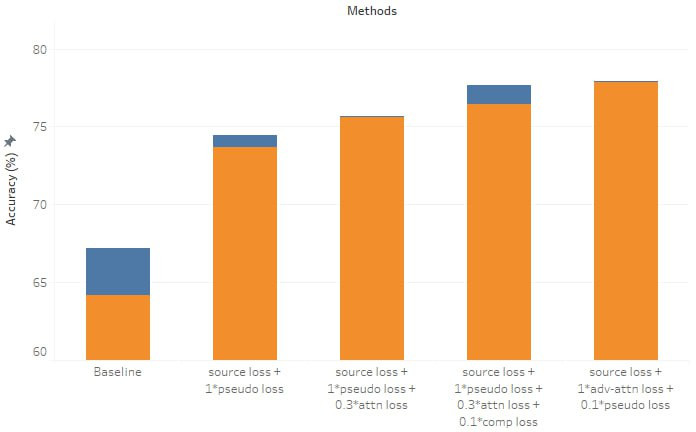

### Real &rarr; Prod

*   Baseline (source loss): 87.47 (last) 87.47 (best)

---

*   DA (source loss + 1\*pseudo loss): 88.22 (last) 89.22 (best)
*   DA (source loss + 1\*pseudo loss + 0.3\*attn loss): 86.97 (last) 88.97 (best)
*   DA (source loss + 1\*pseudo loss + 0.3\*attn loss + 0.1\*comp loss): 84.96 (last) 85.21 (best)

---

*   DA (Ours) (source loss + 1\*adv-attn loss + 0.1\*pseudo loss): **89.22** (last) **90.23** (best)

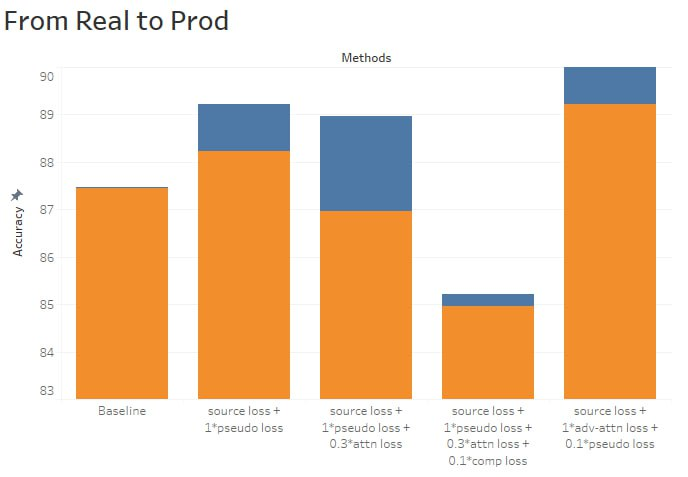

# Ablation Study

In this section we report the results of the ablation study conducted in order to prove the effectiveness of our design choices. In particular, we conducted experiments on 4 different version of our proposed loss in both settings, i.e. Real &rarr; Prod and Prod &rarr; Real, considering different values for the $\lambda$ (lambda) of the GRL and $\delta$ (delta), which is the parameter controlling the modulation of the feature maps.

The 4 versions of our adversarial-attention loss are:


*   adv loss: with $\lambda$ of the GRL fixed to 0.01 and $\delta$ fixed to 0
*   gamma-adv loss: with $\lambda$ of the GRL equal to *gamma* and $\delta$ fixed to 0
*   adv-attn loss: with $\lambda$ of the GRL equal fixed to 0.01 and $\delta$ equal to *gamma*
*   gammas-adv-attn loss: with $\lambda$ of the GRL equal to *gamma* and $\delta$ equal to *gamma*

In the first setting, the best version is gammas-adv-attn loss using just the adversarial-attention loss but, once introduced the pseudo loss, the best version is adv-attn loss, which is also the only one improving over the method of the paper [1].

In the second setting, the best version is adv-attn loss using just the adversarial-attention loss and, once introduced the pseudo loss, the best version are attn loss loss, considering the result in the last epoch, and adv-attn loss, considering the result in the best epoch. To note, that adv-attn loss in the last epoch has a small margin differece with adv-attn loss and still improves the best performance of the DAC-Net method.



### Prod &rarr; Real

*   DA (source loss + 1\*adv loss): 66.92 (last) 66.92 (best)
*   DA (source loss + 1\*gamma-adv loss): 67.17 (last) 70.18 (best)
*   DA (source loss + 1\*adv-attn loss): 64.16 (last) 64.16 (best)
*   DA (source loss + 1\*gammas-adv-attn loss): **69.17** (last) **71.93** (best)

---

*   DA (source loss + 0.1\*pseudo loss): 72.18 (last) 73.18 (best)


*   DA (source loss + 1\*adv loss + 0.1\*pseudo loss): 75.69 (last) 76.19 (best)
*   DA (source loss + 1\*gamma-adv loss + 0.1\*pseudo loss): 62.91 (last) 64.41 (best)
*   DA (source loss + 1\*adv-attn loss + 0.1\*pseudo loss): **77.94** (last) **77.94** (best)
*   DA (source loss + 1\*gammas-adv-attn loss + 0.1\*pseudo loss): 73.43 (last) 75.19 (best)

### Real &rarr; Prod

*   DA (source loss + 1\*adv loss): 87.97 (last) **89.72** (best)
*   DA (source loss + 1\*gamma-adv loss): 87.47 (last) 87.47 (best)
*   DA (source loss + 1\*adv-attn loss): **88.72** (last) **89.72** (best)
*   DA (source loss + 1\*gammas-adv-attn loss): 86.72 (last) 87.97 (best)

---

*   DA (source loss + 0.1\*pseudo loss): 89.47 (last) 89.97 (best)


*   DA (source loss + 1\*adv loss + 0.1\*pseudo loss): **89.97** (last) 89.97 (best)
*   DA (source loss + 1\*gamma-adv loss + 0.1\*pseudo loss): 86.97 (last) 89.22 (best)
*   DA (source loss + 1\*adv-attn loss + 0.1\*pseudo loss): 89.22 (last) **90.23** (best)
*   DA (source loss + 1\*gammas-adv-attn loss + 0.1\*pseudo loss): 88.47 (last) 88.47 (best)

As mentioned in the comments in the code, *gamma* during training changes its value following the same pattern that was proposed by the authors of "Unsupervised Domain Adaptation by Backpropagation" for the $\lambda$ of the GRL. The following plot visualizes the trend of *gamma* during the training procedure.

In [ ]:
def gamma(x):
  return 2 / (1 + np.exp(-10 * x)) - 1

x = np.linspace(0,1, 50)
y = [gamma(i) for i in x]

plt.plot(x, y)
plt.xlabel("current iteration / max iteration")
plt.ylabel("gamma")

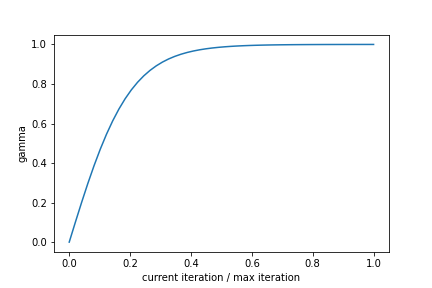

# References

[1] Deng, Zhongying, et al. "Domain attention consistency for multi-source domain adaptation." arXiv preprint arXiv:2111.03911 (2021).

[2] Woo, Sanghyun, et al. "Cbam: Convolutional block attention module." Proceedings of the European conference on computer vision (ECCV). 2018.

[3] Hsu, Cheng-Chun, et al. "Every pixel matters: Center-aware feature alignment for domain adaptive object detector." Computer Vision–ECCV 2020: 16th European Conference, Glasgow, UK, August 23–28, 2020, Proceedings, Part IX 16. Springer International Publishing, 2020.

[4] Ganin, Yaroslav, and Victor Lempitsky. "Unsupervised domain adaptation by backpropagation." International conference on machine learning. PMLR, 2015.